In [0]:
!pip install -q tf-nightly
import tensorflow as tf

     |████████████████████████████████| 520.1MB 19kB/s 
     |████████████████████████████████| 2.9MB 25.3MB/s 
     |████████████████████████████████| 460kB 57.8MB/s 


In [0]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In [0]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk import FreqDist
import nltk
import numpy as np

In [24]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
with open('mex20_train.txt', 'r') as f:
    corpus_train = f.readlines()
    
with open('mex20_train_labels.txt', 'r') as f:
    labels_train = f.readlines()

labels_train = [int(lab.strip('\n')) for lab in labels_train]
tweets_agg_train = [tw for tw, lab in zip(corpus_train, labels_train) if lab == 1]

In [0]:
punct = set(['.', ',', ';', ':', '-', '!', '¡', '¿', '?', '"', '\'', '...', '<url>', '*', '@usuario'])

def process_word(w, punct):
    is_punct = True if w in punct else False
    is_digit = w.isnumeric()
    is_stopword = w in stopwords.words('spanish')

    return "" if is_punct or is_digit else w.lower()

def words_to_ngrams(words, n, sep=" "):
    if n > 1:
        return [tuple(words[i:i+n]) for i in range(len(words)-n+1)]
    else:
        return words

def build_ngrams(tweets, punct, n):
    tk = TweetTokenizer()
    tokens = [process_word(w, punct) for sent in tweets for w in tk.tokenize(sent)]
    tokens = list(filter(None, tokens))
    tw_trigrams = words_to_ngrams(tokens, n)
    tw_trigrams = FreqDist(tw_trigrams)
    
    return tw_trigrams

def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

In [0]:
tw_tokens = build_ngrams(tweets_agg_train, punct, 1)

In [0]:
V = sortFreqDict(tw_tokens)

In [0]:
w2idx = dict()
idx2w = dict()
cont = 0
for weight, word in V:
    w2idx[word] = cont
    idx2w[cont] = word
    cont += 1

In [0]:
sentences_tokens = " ".join([s.strip('\n') for s in tweets_agg_train])
sentences_tokens = sentences_tokens.split(" ")
sentences_tokens = [w for w in sentences_tokens if w in w2idx]

In [0]:
train_X = []
train_y = []

for i in range(len(sentences_tokens) - 5):
    train_X.append([w2idx[w] for w in sentences_tokens[i:i+4]])
    y = np.zeros(len(V))
    last = sentences_tokens[i+5]
    y[w2idx[last]] = 1.
    train_y.append(y)

In [0]:
 p = np.random.permutation(len(train_X))

 train_X = np.array(train_X)[p]
 train_y = np.array(train_y)[p]

# Model

In [0]:
from tensorflow.keras.layers import Input, Dense, Reshape, Embedding, Add, Softmax
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam

In [0]:
embedding_dim = 32
k = 4

z = Input(shape=(4,))
X = Embedding(len(V), embedding_dim, input_length=k)(z)
X = Reshape((k*embedding_dim,))(X)
D = Dense(len(V), input_shape=(k*embedding_dim,))(X)
X = Dense(len(V), input_shape=(k*embedding_dim,))(X)
X = Activation('tanh', dtype='float32')(X)
X = Add()([X,D])
Y = Softmax()(X)

model = Model(inputs = z, outputs = [Y], name ='nn')

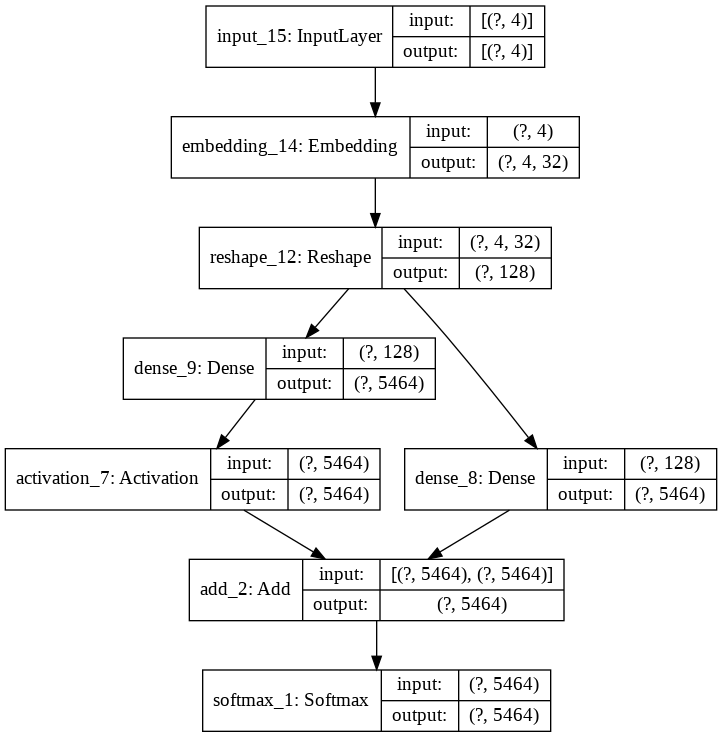

In [83]:
plot_model(model, to_file='nn.png', show_shapes=True)

In [0]:
class LogLikelihood(tf.keras.losses.Loss):
  def call(self, y_true, y_pred):
    y_pred = ops.convert_to_tensor(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    return K.mean(math_ops.square(y_pred - y_true), axis=-1)

In [0]:
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True), 
                optimizer=Adam(), 
                metrics=['accuracy'])

In [113]:
history = model.fit(train_X, train_y,
                    batch_size=64,
                    epochs=100,
                    validation_split=0.2)

Epoch 1/100
230/230 [==============================] - 7s 31ms/step - loss: 8.6059 - accuracy: 0.0434 - val_loss: 8.6059 - val_accuracy: 0.0482
Epoch 2/100
230/230 [==============================] - 7s 31ms/step - loss: 8.5910 - accuracy: 0.0495 - val_loss: 8.5658 - val_accuracy: 0.0482
Epoch 3/100
230/230 [==============================] - 7s 30ms/step - loss: 8.5603 - accuracy: 0.0495 - val_loss: 8.5623 - val_accuracy: 0.0482
Epoch 4/100
230/230 [==============================] - 7s 30ms/step - loss: 8.5572 - accuracy: 0.0495 - val_loss: 8.5618 - val_accuracy: 0.0485
Epoch 5/100
230/230 [==============================] - 7s 30ms/step - loss: 8.5548 - accuracy: 0.0510 - val_loss: 8.5613 - val_accuracy: 0.0482
Epoch 6/100
230/230 [==============================] - 7s 31ms/step - loss: 8.5470 - accuracy: 0.0644 - val_loss: 8.5601 - val_accuracy: 0.0501
Epoch 7/100
230/230 [==============================] - 7s 30ms/step - loss: 8.5391 - accuracy: 0.0710 - val_loss: 8.5593 - val_accuracy:

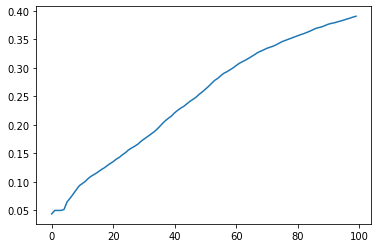

In [114]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])

Get embeddings

In [119]:
e = model.layers[1]
weights = e.get_weights()[0]
print(weights.shape)

(5464, 32)


Apply t-sne for the first 1000 words

In [121]:
from tsne import tsne

reduced_matrix = tsne(weights[:1000,], 2)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1000...
Computing P-values for point 500 of 1000...
Mean value of sigma: 0.648196
Iteration 10: error is 17.855724
Iteration 20: error is 17.186733
Iteration 30: error is 17.222557
Iteration 40: error is 17.206259
Iteration 50: error is 17.191917
Iteration 60: error is 17.256621
Iteration 70: error is 17.284496
Iteration 80: error is 17.370781
Iteration 90: error is 17.330600
Iteration 100: error is 17.510286
Iteration 110: error is 2.337233
Iteration 120: error is 1.966354
Iteration 130: error is 1.824017
Iteration 140: error is 1.741664
Iteration 150: error is 1.688091
Iteration 160: error is 1.638228
Iteration 170: error is 1.611024
Iteration 180: error is 1.589390
Iteration 190: error is 1.573789
Iteration 200: error is 1.561289
Iteration 210: error is 1.550836
Iteration 220: error is 1.542168
Iteration 230: error is 1.534840
Iteration 240: error is 1.528462
Iteration 250: error is

In [0]:
max_x = np.amax(reduced_matrix, axis=0)[0]
max_y = np.amax(reduced_matrix, axis=0)[1]

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129315 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129315 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128405 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128405 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127995 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127995 missing from current font.
  font.se

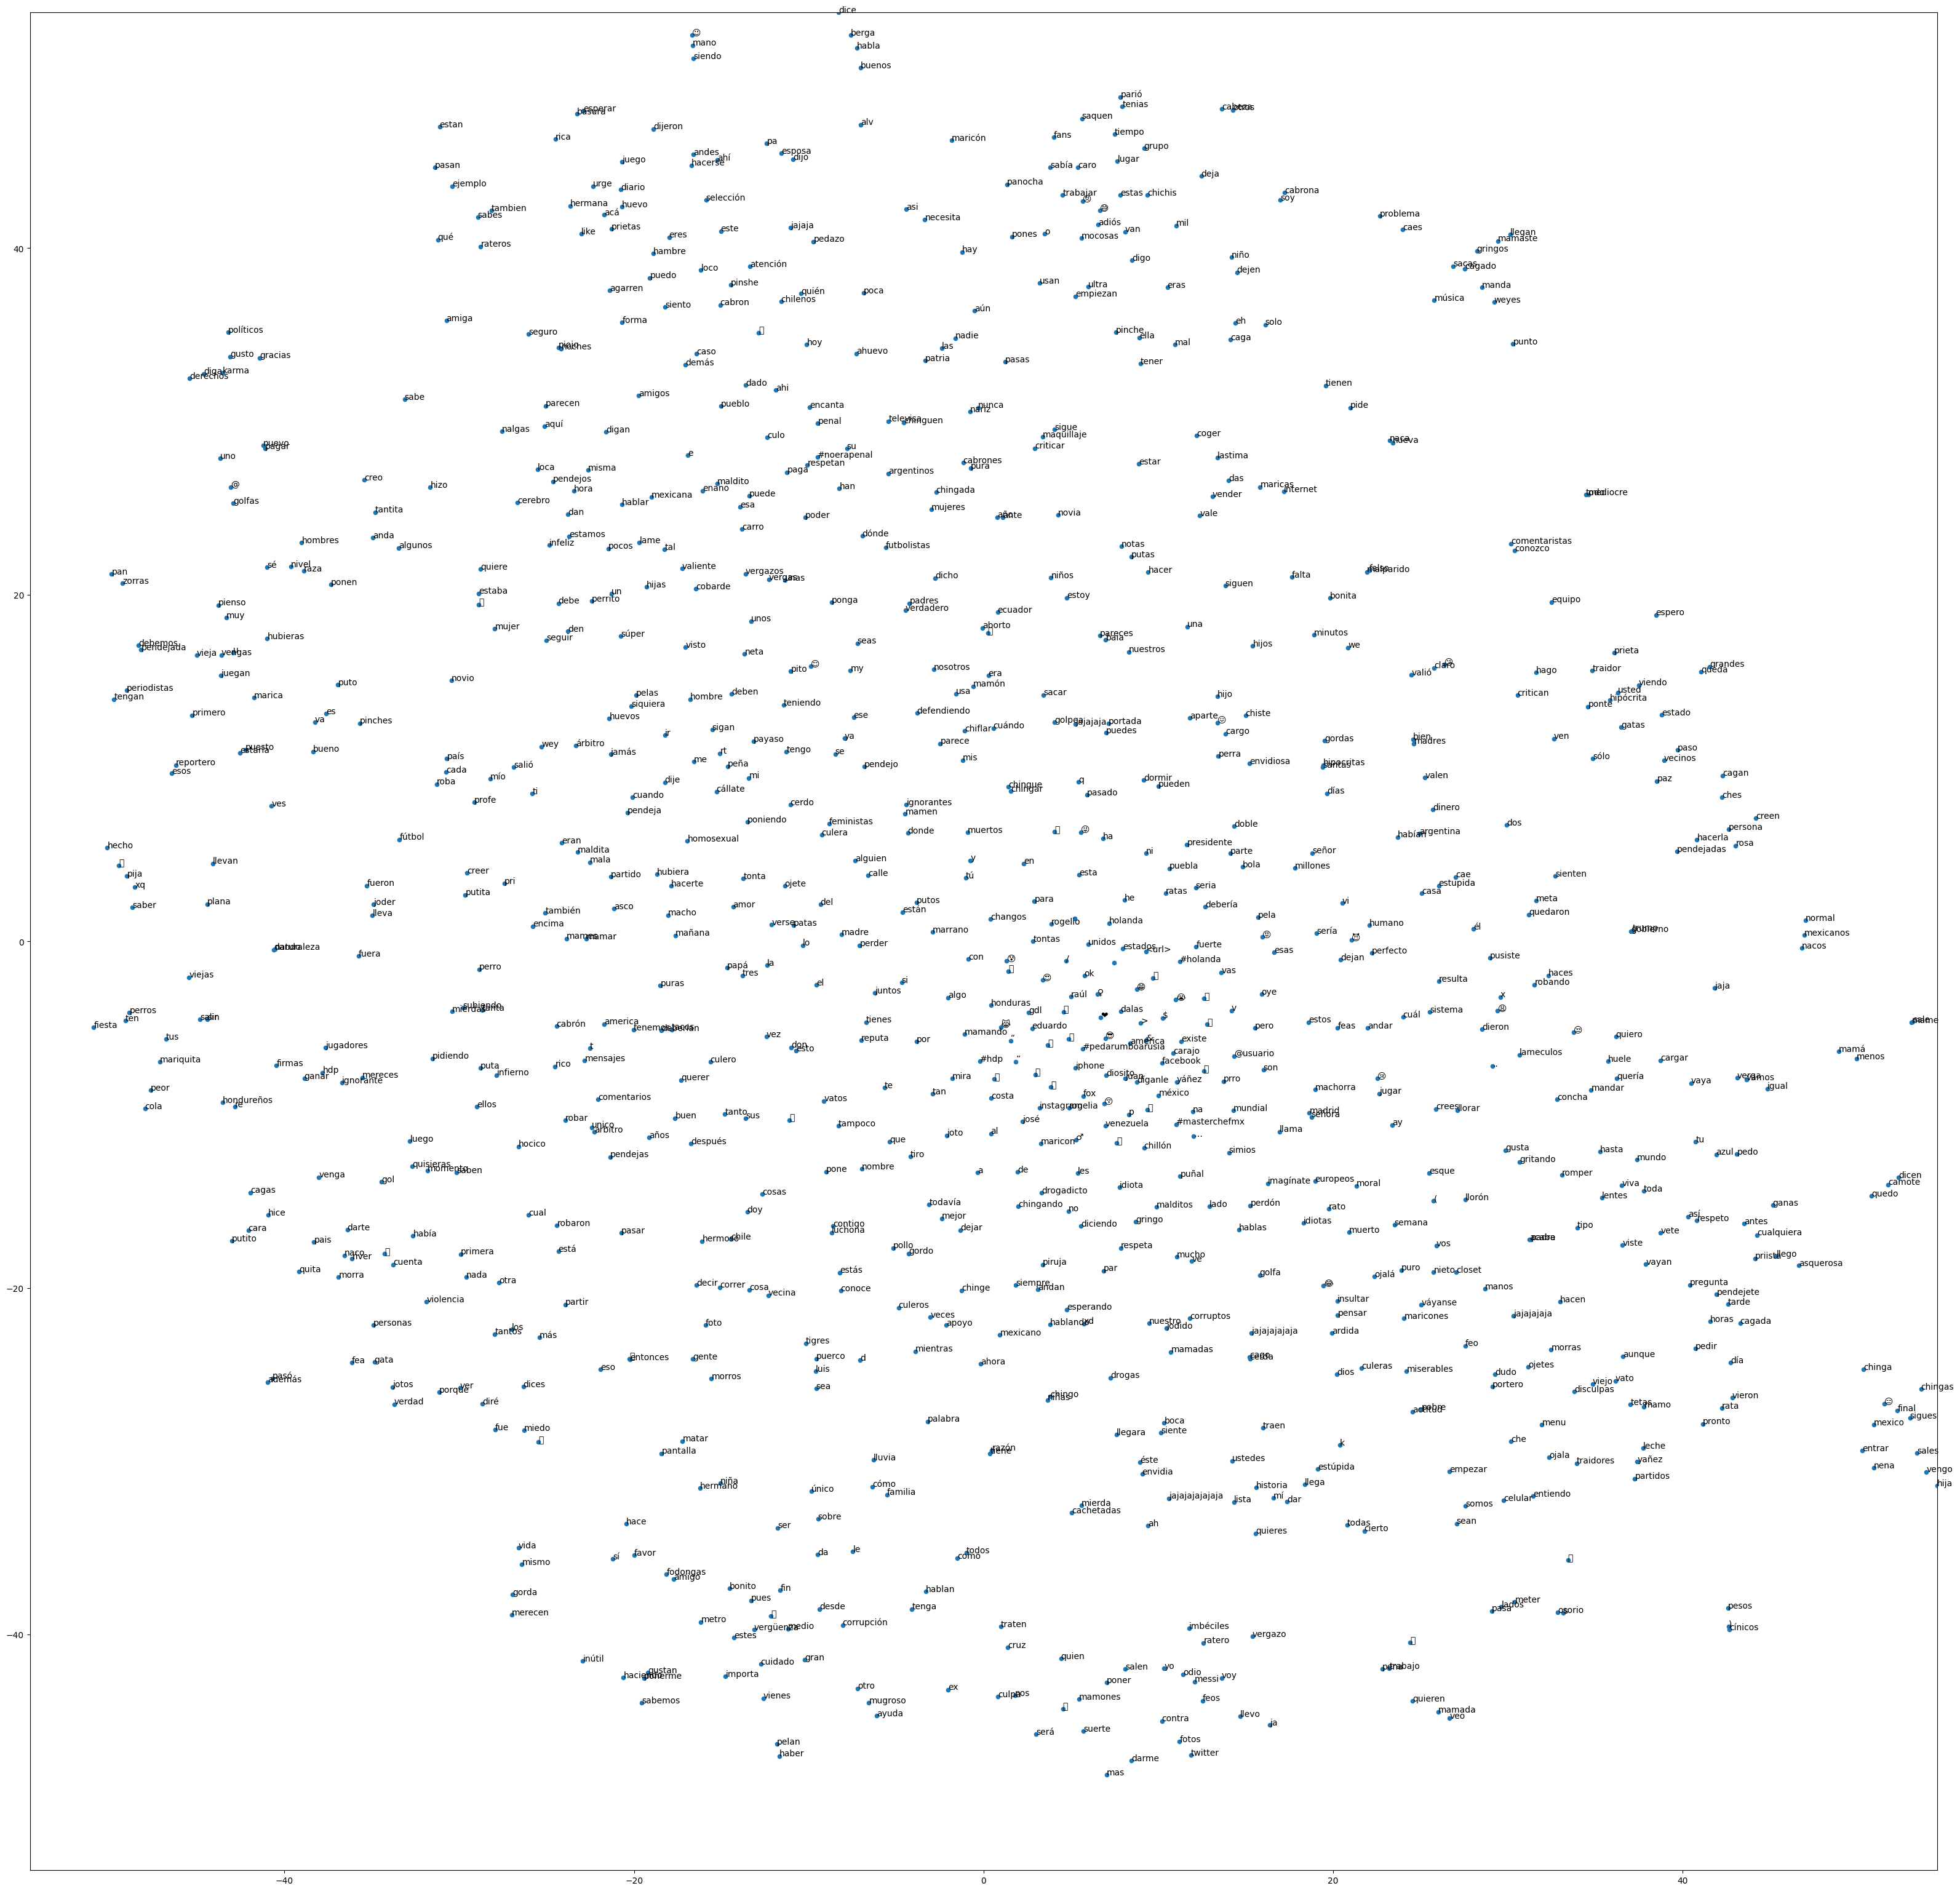

In [124]:
plt.figure(figsize=(40, 40), dpi=100); plt.xlim((-max_x,max_x)); plt.ylim((-max_y,max_y))
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], 20);
for idx, word in idx2w.items():
    if idx < 1000:
        x = reduced_matrix[idx, 0]
        y = reduced_matrix[idx, 1]
        plt.annotate(word, (x,y))